In [25]:
import numpy as np
import scipy.ndimage
import scipy.stats
import pandas

import numba

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Halo catalog

We use the ROCKSTAR halo catalog from Bolshoi-Planck, for a single snapshot: `a = 0.28850` for `z ~ 2.5`, and `a = 0.45556` for `z ~ 1.2`.

The halo catalogs are paired with the corresponding dark matter binned density for the same snapshot. `TWEB_EIGENVEC_PATH` is where the deformation tensor eigenvectors are cached, so we only have to compute them once (since it's a very time and memory intensive operation).

In [2]:
z2_5 = False

if z2_5:
    HALO_CAT_PATH = 'data/hlist_0.28850.list'
    SIM_DENSITY_PATH = 'data/dens_0094.bin'
    TWEB_EIGENVEC_PATH = 'data/z2.5-tweb-eigenvec.npy'
else:
    HALO_CAT_PATH = 'data/hlist_0.45556.list'
    SIM_DENSITY_PATH = 'data/dens_0127.bin'
    TWEB_EIGENVEC_PATH = 'data/z1.2-tweb-eigenvec.npy'

`x/y/z_snap` is the halo's position in Mpc/h, while `ax/ay/az_snap` is the halo's longest-axis vector, or its "shape". It's also in Mpc/h, though we normalize it so the length doesn't matter.

In [3]:
halo_cat = pandas.read_csv(HALO_CAT_PATH, header=None, comment='#', delim_whitespace=True)
named_cols = {1: 'id', 10: 'mvir_snap', 17: 'x_snap', 18: 'y_snap', 19: 'z_snap', 48: 'ax_snap', 49: 'ay_snap', 50: 'az_snap'}
halo_cat.rename(columns=named_cols, inplace=True)
halo_cat = halo_cat[named_cols.values()]
halo_cat.dropna(inplace=True)

In [4]:
halo_cat.head()

,id,mvir_snap,x_snap,y_snap,z_snap,ax_snap,ay_snap,az_snap
0,1396669844,1.050000e+14,35.89050,42.84833,18.69807,85.04220,-46.89590,-6.75773
1,1396669845,1.457000e+10,35.89394,43.07526,18.55927,2.55782,5.05327,-4.26330
2,1396669846,8.368000e+09,35.98213,42.89507,18.83903,1.98632,3.66820,0.29241
3,1396669848,4.649000e+09,35.78321,43.07677,18.87197,7.98919,8.44344,4.15659
4,1396669849,4.649000e+09,35.75792,42.86027,18.47008,-3.64369,1.87966,5.74206


In [5]:
halo_positions = halo_cat[['x_snap', 'y_snap', 'z_snap']].to_numpy()
halo_shapes = halo_cat[['ax_snap', 'ay_snap', 'az_snap']].to_numpy()

# Cosmic web deformation tensor

We compute the deformation tensor eigenvectors from the binned DM density and save them.

We smooth the density before computing the deformation tensor, so the tensor doesn't vary wildly from point to point. We follow Krolewski et al. 2016, and smooth with a constant 2 Mpc/h Gaussian kernel. Due to memory constraints, we also spline-interpolate the density down from 1024 pixels to 512 pixels.

As a reminder, the eigenvectors of the deformation tensor are $\vec{e_1}, \vec{e_2}, \vec{e_3}$, which are sorted in descending order by their corresponding eigenvalues.
The direction of cosmic web filaments is along $\vec{e_3}$, as is the plane of cosmic web sheets.

The output of `compute_deformation_tensor()` is a `512 x 512 x 512 x 3 x 3` ndarray. The `3 x 3` matrix at each point is the deformation tensor eigenvectors, but slicing along the 1st and not the 0th axis of the matrix yields the tensor eigenvectors.

In [6]:
# Credit to Alex Krolewski.
def compute_deformation_tensor(dm_density):
	delta_k = np.fft.fftn(dm_density)
	kx = np.fft.fftfreq(len(delta_k))
	ky = np.fft.fftfreq(len(delta_k))
	kz = np.fft.fftfreq(len(delta_k))
	kx_3d,ky_3d,kz_3d = np.meshgrid(kx,ky,kz)
	ksq_3d = kx_3d**2 + ky_3d**2 + kz_3d**2

	t_kxkx = kx_3d*kx_3d*delta_k/ksq_3d
	t_kxky = kx_3d*ky_3d*delta_k/ksq_3d
	t_kxkz = kx_3d*kz_3d*delta_k/ksq_3d
	t_kyky = ky_3d*ky_3d*delta_k/ksq_3d
	t_kykz = ky_3d*kz_3d*delta_k/ksq_3d
	t_kzkz = kz_3d*kz_3d*delta_k/ksq_3d

	t_kxkx[0,0,0] = 0
	t_kxky[0,0,0] = 0
	t_kxkz[0,0,0] = 0
	t_kyky[0,0,0] = 0
	t_kykz[0,0,0] = 0
	t_kzkz[0,0,0] = 0

	t_xx = np.fft.ifftn(t_kxkx)
	t_xy = np.fft.ifftn(t_kxky)
	t_xz = np.fft.ifftn(t_kxkz)
	t_yy = np.fft.ifftn(t_kyky)
	t_yz = np.fft.ifftn(t_kykz)
	t_zz = np.fft.ifftn(t_kzkz)

	t_xx = np.real(t_xx)
	t_xy = np.real(t_xy)
	t_xz = np.real(t_xz)
	t_yy = np.real(t_yy)
	t_yz = np.real(t_yz)
	t_zz = np.real(t_zz)

	t_ij = np.array([[t_xx,t_xy,t_xz],[t_xy,t_yy,t_yz],[t_xz,t_yz,t_zz]])
	t_ij_trans = np.transpose(t_ij,axes=(2,3,4,0,1))

	e = np.linalg.eigh(t_ij_trans)
	return e

**Warning: if computing the deformation tensor from scratch, the notebook takes >60 GB of memory; when loading a cached deformation tensor, the notebook takes ~20 GB in total.**

In [7]:
SIM_MPC_LEN = 250
TWEB_SMOOTHING_SCALE_MPC = 2

try:
    tweb_eigenvec = np.load(TWEB_EIGENVEC_PATH)
except FileNotFoundError:
    dm_density = np.fromfile(SIM_DENSITY_PATH, '<f4').astype(np.float64)
    dm_density = np.reshape(dm_density, (1024,1024,1024), order='F')
    # Down-interpolate density.
    dm_density = scipy.ndimage.zoom(dm_density, 0.5)
    mpc_per_pix = SIM_MPC_LEN / dm_density.shape[0]
    # Gaussian smooth.
    dm_density = scipy.ndimage.gaussian_filter(dm_density, TWEB_SMOOTHING_SCALE_MPC / mpc_per_pix)
    tweb_eigenvec = compute_deformation_tensor(dm_density)[1]
    np.save(TWEB_EIGENVEC_PATH, tweb_eigenvec)

In [8]:
tweb_npix = tweb_eigenvec.shape[0]

# 3D Alignment

For each halo, we pick out the nearest grid point's eigenvector and compute the absolute value of the halo's longest-axis/shape vector, $\vec{s}$ and the eigenvector.

We take the absolute value since both the longest-axis vector and its negative describe the same thing.

According to tidal alignment theory, halo shapes preferentially align with filaments and along sheets, which $\vec{e_3}$ points along in both cases. When looking at the distribution of dot products, we expect to see, and do see, a bias towards 1. Lots of other studies have shown this for simulated halos at $z \sim 0$ (see [here](https://ui.adsabs.harvard.edu/abs/2014MNRAS.443.1090F/abstract) or [here](https://ui.adsabs.harvard.edu/abs/2013MNRAS.428.2489L/abstract)).

In [9]:
# eigenvec_index = 0/1/2 for e_3/e_2/e_1.
@numba.njit
def nearest_eigenvecs(positions, eigenvec_index):
    tweb = tweb_eigenvec[:, :, :, :, eigenvec_index]
    nearest_eigenvecs = np.zeros_like(positions)
    for i, pos_mpc in enumerate(positions):
        pos_pix = pos_mpc * tweb_npix / SIM_MPC_LEN
        # Hack since numba's implementation of np.round doesn't work.
        pos_pix = np.array([round(pos_pix[0]), round(pos_pix[1]), round(pos_pix[2])])
        rounded_pix = np.minimum(pos_pix, tweb_npix - 1)
        nearest_eigenvecs[i] = tweb[rounded_pix[0], rounded_pix[1], rounded_pix[2], :]
    return nearest_eigenvecs

In [10]:
halo_e3 = nearest_eigenvecs(halo_positions, 0)

In [11]:
assert np.sum(np.isfinite(halo_e3)) == len(halo_e3.flatten())
assert np.sum(np.isfinite(halo_shapes)) == len(halo_shapes.flatten())

In [12]:
@numba.njit
def dot_product(eigenvecs, shapes):
    norm_eigenvecs = eigenvecs / np.sqrt(eigenvecs[:, 0]**2 + eigenvecs[:, 1]**2 + eigenvecs[:, 2]**2).reshape(-1, 1)
    norm_shapes = shapes / np.sqrt(shapes[:, 0]**2 + shapes[:, 1]**2 + shapes[:, 2]**2).reshape(-1, 1)
    dot = np.array([np.dot(norm_eigenvecs[i], norm_shapes[i]) for i in range(len(norm_eigenvecs))])
    return np.abs(dot)

In [13]:
e3_align = dot_product(halo_e3, halo_shapes)
# Some of the shape vectors are all zeros, which leads to nan.
print(f'{np.sum(np.isnan(e3_align))} dot products are NaN, out of {len(e3_align)}.')
e3_align = e3_align[~np.isnan(e3_align)]

<ipython-input-12-17bd9cec8cbb>:5: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, A))
  dot = np.array([np.dot(norm_eigenvecs[i], norm_shapes[i]) for i in range(len(norm_eigenvecs))])


91653 dot products are NaN, out of 16659142.


In [23]:
print(f'Sanity check: dot product min/max is {np.min(e3_align)} / {np.max(e3_align)}')

Sanity check: dot product min/max is 7.58427998182043e-09 / 0.9999999680808498


To make the trend clearer, we plot the dot product as a density histogram of 5 bins. The horizontal line at `y = 1` is the null case of no alignment trend.

We also calculate the chi-squared metric and p-value for the (non-density) histogram bins.

Chi-squared = 2.81e+03 | P-value = 0.0


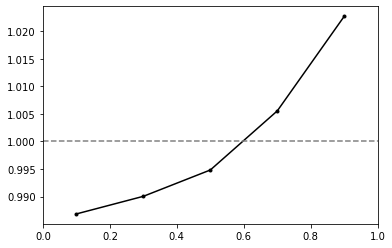

In [34]:
num, edges = np.histogram(e3_align, bins=5, density=True)
centers = 0.5 * (edges[1:] + edges[:-1])

plt.plot(centers, num, 'k.-')
plt.xlim(0, 1)
plt.axhline(1, linestyle='--', color='grey')

chi_sq, chi_sq_pval = scipy.stats.chisquare(np.histogram(e3_align, bins=5)[0])
print(f'Chi-squared = {chi_sq:.3} | P-value = {chi_sq_pval:.3}')

# 2D Alignment

Since in practice we can't measure the true 3D extent of galaxies, and can only measure their projections onto the sky, we want to see if an alignment trend in 3D space translates to one we can measure on the sky, which we call the 2D alignment.

To do this, we vector-project all halo shape vectors **and** $\vec{e_3}$ onto the plane normal to a chosen line-of-sight vector. We then repeat the dot product calculation.

The null distribution of dot products we compare to is more complicated than in the 3D case--instead of being flat, it takes the form of $2Beta(0.5, 0.5) - 1$ where $Beta$ is the beta distribution with parameters $\alpha = \beta = 1/2$. This is because we can model no 3D alignment trend as pairs of uncorrelated random-direction vectors. (Derived [here](https://stats.stackexchange.com/questions/85916/distribution-of-scalar-products-of-two-random-unit-vectors-in-d-dimensions)).

Since we only care about the absolute value of the dot products, we multiply the PDF of the null distribution by 2, and only look at the PDF between 0 and 1.

The null distribution has a mean angle of $\frac{\pi}{4}$ between the two vectors, so we also compute Krolewski's summary statistic for how strong the 2D alignment trend is: $\overline{arccos(\vec{s} \bullet \vec{e_3})} - \frac{\pi}{4}$. The more negative this summary statistic is, the stronger the 2D alignment trend is.

Because of the cosmological principle, we expect the 2D alignment trend for all halos in the snapshot to be **about the same regardless of the line-of-sight chosen**; if we randomly choose a bunch of lines of sight in random directions, the 2D alignment along them should be vaguely normally distributed.

**For the Bolshoi-Planck snapshot, we're not seeing this.** Instead, for a single preferred direction, we see an absurdly strong 2D alignment, and almost no trend in all other directions.

In [36]:
@numba.njit
def project_onto_plane(vecs, plane_norm_vec):
    projected_vecs = np.zeros_like(vecs)
    for i, v in enumerate(vecs):
        v_norm = np.dot(v, plane_norm_vec) / np.dot(plane_norm_vec, plane_norm_vec) * plane_norm_vec
        v_perp = v - v_norm
        projected_vecs[i] = v_perp
    return projected_vecs

In [43]:
random_los_mean_angle = []
random_los_dot = []
np.random.seed(42)

for _ in range(100):
    random_los = np.random.randn(3)
    random_los /= np.linalg.norm(random_los)
    
    proj_e3 = project_onto_plane(halo_e3.copy(), random_los)
    proj_shapes = project_onto_plane(halo_shapes.copy(), random_los)
    proj_dot = dot_product(proj_e3, proj_shapes)
    proj_dot = proj_dot[~np.isnan(proj_dot)]
    
    random_los_mean_angle.append(np.mean(np.arccos(proj_dot)) - np.pi / 4)
    random_los_dot.append(proj_dot)

(array([ 4.,  0.,  1.,  0.,  2.,  3.,  3.,  2.,  2.,  1.,  1.,  1.,  2.,
         7.,  2.,  3.,  9.,  7., 21., 29.]),
 array([-0.01526911, -0.01448736, -0.01370562, -0.01292387, -0.01214212,
        -0.01136038, -0.01057863, -0.00979689, -0.00901514, -0.00823339,
        -0.00745165, -0.0066699 , -0.00588815, -0.00510641, -0.00432466,
        -0.00354292, -0.00276117, -0.00197942, -0.00119768, -0.00041593,
         0.00036582]),
 <BarContainer object of 20 artists>)

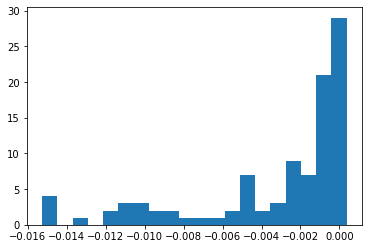

In [44]:
plt.hist(random_los_mean_angle, bins=20)

In [45]:
def plot_2d_alignment(dot_products, n_bins=5):
    # s is the size of the sample to draw.
    null_dist = lambda s: np.abs(scipy.stats.beta.rvs(0.5, 0.5, loc=-1, scale=2, size=s))
    null_cdf = lambda x: 2 * (scipy.stats.beta.cdf(x, 0.5, 0.5, loc=-1, scale=2) - scipy.stats.beta.cdf(0, 0.5, 0.5, loc=-1, scale=2))
    
    num, edges = np.histogram(dot_products, bins=n_bins, density=True)
    centers = 0.5 * (edges[1:] + edges[:-1])
    
    # Subtract out null distribution's expected density for each bin.
    null_num = np.array([null_cdf(edges[i + 1]) - null_cdf(edges[i]) for i in range(len(num))]) * n_bins
    num -= null_num
    
    plt.plot(centers, num, 'k.-')
    plt.xlim(0, 1)
    plt.axhline(0, linestyle='--', color='grey')

    # Compute chi-squared against non-uniform null distribution.
    chi_sq, chi_sq_pval = scipy.stats.chisquare(np.histogram(dot_products, bins=n_bins)[0], f_exp=null_num / n_bins * len(dot_products))
    print(f'Chi-squared = {chi_sq:.3} | P-value = {chi_sq_pval:.3}')

Most negative mean-angle statistic: strongest 2D alignment trend.
Chi-squared = 1.77e+04 | P-value = 0.0


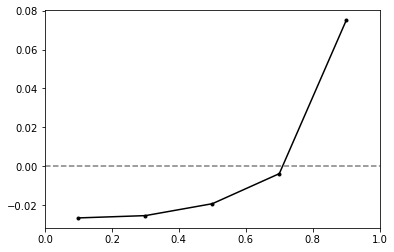

Most positive mean-angle statistic: weakest 2D alignment trend.
Chi-squared = 11.5 | P-value = 0.021


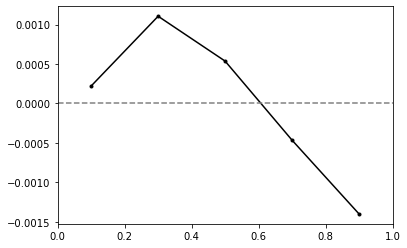

In [48]:
# Plot most negative and least negative mean-angles' 2D alignment histograms.
print('Most negative mean-angle statistic: strongest 2D alignment trend.')
plot_2d_alignment(random_los_dot[np.argmin(random_los_mean_angle)])

plt.show()

print('Most positive mean-angle statistic: weakest 2D alignment trend.')
plot_2d_alignment(random_los_dot[np.argmax(random_los_mean_angle)])